SMOTE 적용 전 학습 데이터 크기: (4038, 25), 환자 수: 1409
SMOTE 적용 후 학습 데이터 크기: (5258, 25), 환자 수: 2629

[1. SMOTE 적용 후 알고리즘별 성능 비교]
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.754455   0.625604  0.735795  0.676240  0.832019
4    Gradient Boosting  0.745545   0.616137  0.715909  0.662286  0.822119
3             LightGBM  0.747525   0.632153  0.659091  0.645341  0.820047
1        Random Forest  0.740594   0.616580  0.676136  0.644986  0.811529
2              XGBoost  0.734653   0.617318  0.627841  0.622535  0.804577


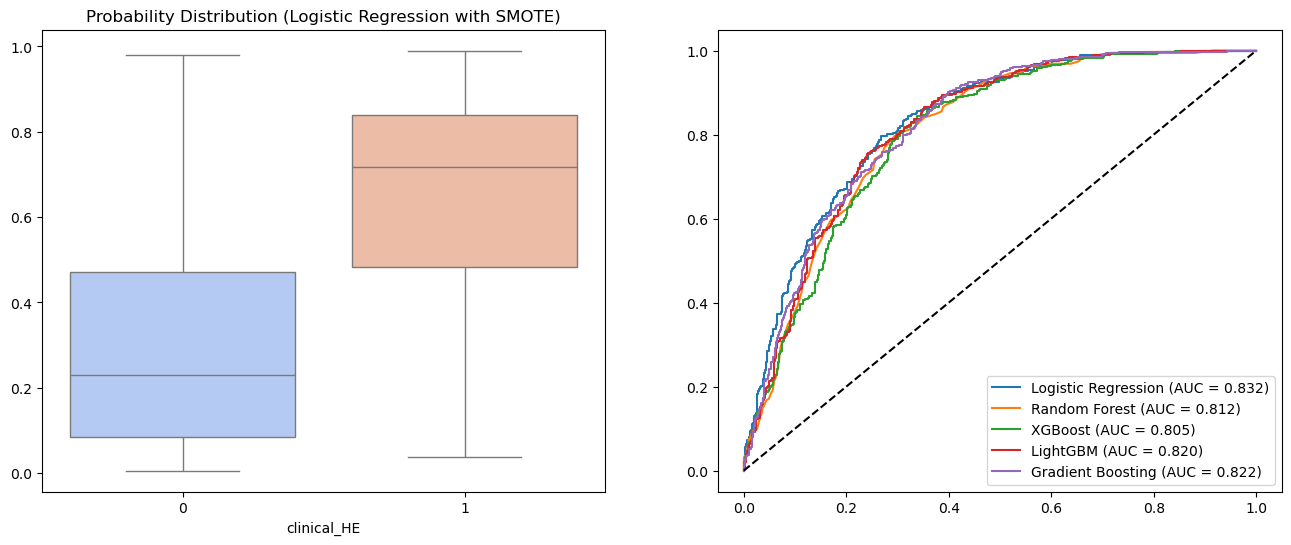

성공적으로 '고혈압.xlsx' 파일이 저장되었습니다.

[저장된 데이터 확인]
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.754455   0.625604  0.735795  0.676240  0.832019
4    Gradient Boosting  0.745545   0.616137  0.715909  0.662286  0.822119
3             LightGBM  0.747525   0.632153  0.659091  0.645341  0.820047
1        Random Forest  0.740594   0.616580  0.676136  0.644986  0.811529
2              XGBoost  0.734653   0.617318  0.627841  0.622535  0.804577
--- 등급 결정 기준점 (점수) ---
주의 시작: 16.54점 | 위험 시작: 32.60점 | 고위험 시작: 44.51점

   Risk_Score       Risk_Grade
0   35.367666        위험 (High)
1   24.855807    주의 (Moderate)
2   41.595909        위험 (High)
3   15.996758         안전 (Low)
4   55.028308  고위험 (Very High)
5   11.094529         안전 (Low)
6   50.989664  고위험 (Very High)
7   17.727038    주의 (Moderate)
8   19.829047    주의 (Moderate)
9   37.623679        위험 (High)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score, precision_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# SMOTE 라이브러리 추가
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

# [고정] 난수 시드 설정
SEED = 42
np.random.seed(SEED)

# 1. 데이터 로드
file_path = "D:/semi2/MH/df/질환별/분석용.csv" 
df = pd.read_csv(file_path, encoding='cp949')

# 분석 특성 및 타겟 설정
features = ['age', 'sex', 'edu', 'incm', 'occp', 'marry', 'FH_HE','FH_DY', 'FH_HAA', 'FH_ST', 'FH_DB', 'FH_OS',
            'HE_obe', 'HE_ht', 'HE_wt', 'HE_BMI', 'smoking', 'alcohol', 'pa_aerobic', 'sleep_time_wy', 'sleep_time_wd',
            'mh_PHQ_S', 'mh_GAD_S', 'BP1', 'EQ5D']
target = 'clinical_HE'

X_raw = df[features]
y = df[target]

# 2. 데이터 분할 (층화 추출 적용)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=SEED, stratify=y)

# 3. 데이터 전처리 (표준화)
standardize_vars = ['mh_PHQ_S', 'mh_GAD_S', 'EQ5D']
scaler = StandardScaler()
X_train[standardize_vars] = scaler.fit_transform(X_train[standardize_vars])
X_test[standardize_vars] = scaler.transform(X_test[standardize_vars])

# ---------------------------------------------------------
# 4. SMOTE 적용 (훈련 데이터에만 적용)
# ---------------------------------------------------------
print(f"SMOTE 적용 전 학습 데이터 크기: {X_train.shape}, 환자 수: {y_train.sum()}")

smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"SMOTE 적용 후 학습 데이터 크기: {X_train_resampled.shape}, 환자 수: {y_train_resampled.sum()}")
# ---------------------------------------------------------

# 5. 모델 리스트 정의
models = [
    ("Logistic Regression", LogisticRegression(random_state=SEED)),
    ("Random Forest", RandomForestClassifier(n_estimators=100, random_state=SEED)),
    ("XGBoost", XGBClassifier(eval_metric='logloss', random_state=SEED)),
    ("LightGBM", LGBMClassifier(verbose=-1, random_state=SEED)),
    ("Gradient Boosting", GradientBoostingClassifier(random_state=SEED))
]

# 6. 모델 학습(오버샘플링 데이터 사용) 및 성능 평가
perf_results = []
model_probs = {}

for name, model in models:
    # 오버샘플링된 데이터로 학습
    model.fit(X_train_resampled, y_train_resampled)
    
    # 평가는 원본 테스트 데이터로 수행
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    model_probs[name] = y_prob
    
    perf_results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

# 7. 결과 출력 및 시각화
comparison_table = pd.DataFrame(perf_results).sort_values(by="ROC-AUC", ascending=False)
print("\n[1. SMOTE 적용 후 알고리즘별 성능 비교]")
print(comparison_table)

# 시각화 (기존과 동일하되 최우수 모델 기준)
best_model_name = comparison_table.iloc[0]['Model']
best_probs = model_probs[best_model_name]

plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=y_test, y=best_probs, palette='coolwarm')
plt.title(f'Probability Distribution ({best_model_name} with SMOTE)')

plt.subplot(1, 2, 2)
for name in model_probs:
    fpr, tpr, _ = roc_curve(y_test, model_probs[name])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, model_probs[name]):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

def calculate_risk_grades(model_probs):
    """
    모델의 확률값을 기반으로 100점 만점 점수와 분위수 기반 등급을 계산합니다.
    """
    # 1. 모델 확률을 100점 만점 점수로 변환 (방법 B 기반)
    risk_scores = model_probs * 100
    
    # 2. 분위수(Percentile) 기준점 계산 (방법 A 기반)
    # 하위 30%(안전), 70%(주의), 90%(위험), 그 이상(고위험)
    thresholds = np.percentile(risk_scores, [30, 70, 90])
    
    grades = []
    for score in risk_scores:
        if score <= thresholds[0]:
            grades.append("안전 (Low)")
        elif score <= thresholds[1]:
            grades.append("주의 (Moderate)")
        elif score <= thresholds[2]:
            grades.append("위험 (High)")
        else:
            grades.append("고위험 (Very High)")
            
    return risk_scores, grades, thresholds

# --- 실제 적용 예시 ---
# 가정: 고혈압 모델의 예측 확률 결과 (X_test에 대한 결과라고 가정)
# test_probs = best_model.predict_proba(X_test)[:, 1]

# 예시 데이터 생성 (0~1 사이의 확률값 100개)
np.random.seed(42)
sample_probs = np.random.beta(2, 5, 100) # 실제 질환 데이터와 유사한 분포 생성

scores, grades, cut_offs = calculate_risk_grades(sample_probs)

# 결과 데이터프레임 구성
result_df = pd.DataFrame({
    'Risk_Score': scores,
    'Risk_Grade': grades
})

print(f"--- 등급 결정 기준점 (점수) ---")
print(f"주의 시작: {cut_offs[0]:.2f}점 | 위험 시작: {cut_offs[1]:.2f}점 | 고위험 시작: {cut_offs[2]:.2f}점\n")
print(result_df.head(10))

In [ ]:
import pandas as pd

# 1. 제공해주신 데이터를 데이터프레임으로 구성
data = (comparison_table)

df_results = pd.DataFrame(data)

# 2. 엑셀 파일로 저장
file_name = "고혈압.xlsx"

try:
    # index=False 옵션으로 행 번호는 제외하고 저장합니다.
    df_results.to_excel(file_name, index=False, engine='openpyxl')
    print(f"성공적으로 '{file_name}' 파일이 저장되었습니다.")
except ImportError:
    print("엑셀 저장을 위해 'openpyxl' 라이브러리가 필요합니다. 'pip install openpyxl'을 실행해주세요.")

# 저장된 데이터 확인 (출력용)
print("\n[저장된 데이터 확인]")
print(df_results)